# Risk Based Authentication 

Trabalho Realizado por:

- Bernardo Coelho nº 98445
- Francisco Camilo nº99234
- Simão Miguel nº 99064
- Tiago Coelho nº 105176


A nossa base de dados escolhida é relativa a histórico de tentativas de login.
Foi definido ao longo do projeto que o objetivo seria determinar se um login poderia ser ou não um ataque de IP

Para tal fizemos 4 notebooks , cada um com objetivos diferente:
- Extract, transform and load (ETL)- neste notebook irá ser feita uma limpeza e tratamento, serão escolhidas as variáveis a utiizar para o modelo
- Análise exploratória-> neste notebook iremos verificar e analisar os dados
- Treino e afinação do modelo -> neste notebook irá ser criado o modelo para o objetivo final de determinar se se um login pode ser ou não um ataque de IP
- Deployment do modelo -> iremos ver os resultados do modelo


In [2]:
import pyspark
import pyspark.sql.functions as F 
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [4]:
df = spark.read.parquet('/home/jovyan/code/Projeto/login.parquet')

## Verificação dos Dados

In [5]:
df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- Login Timestamp: timestamp (nullable = true)
 |-- IP Address: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ASN: integer (nullable = true)
 |-- Browser Name and Version: string (nullable = true)
 |-- OS Name and Version: string (nullable = true)
 |-- Device Type: string (nullable = true)
 |-- Login Successful: boolean (nullable = true)
 |-- Is Attack IP: boolean (nullable = true)
 |-- ip_classification: string (nullable = true)
 |-- Prev_Is_Attack_IP: boolean (nullable = true)
 |-- Dangerous IP: boolean (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- hashed_browser: integer (nullable = true)
 |-- hashed_OS: integer (nullable = true)
 |-- dtIndex: double (nullable = true)
 |-- dtohc: vector (nullable = true)
 |-- hashed_country: integer (nullable = true)
 |-- hashed_ASN: integer (nullable = true)

In [6]:
df.count()

1563607

### Descritivas das variáveis numéricas

In [7]:
def describe_numeric_cols_v2(df):
    numeric_cols = ["Year","Month","Day"]
    return df.select(numeric_cols).describe().toPandas().transpose()

describe_numeric_cols_v2(df)

,0,1,2,3,4
summary,count,mean,stddev,min,max
Year,1563607,2020.1696059175995,0.3752863445269464,2020,2021
Month,1563607,6.38261532469476,3.723942755713649,1,12
Day,1563607,15.809895964906783,8.86917197667698,1,31


Observa-se que não existe nenhum outlier nestas variáveis , pois os valores estão dentro dos valores esperados 

### Variáveis categóricas interessantes

#### Logins por País

In [8]:
df.groupBy('Country') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+-------+------+
|Country| count|
+-------+------+
|     NO|660353|
|     US|434486|
|     RU| 84441|
|     BR| 58982|
|     DE| 45034|
|     PL| 42563|
|     IN| 22028|
|     GB| 21358|
|     UA| 20367|
|     AU| 19653|
+-------+------+
only showing top 10 rows



Os 10 países com mais logins são:
- 1- Noruega (NO), com 660.353 logins.
- 2- Estados Unidos (US), com 434.486 logins.
- 3- Rússia (RU), com 84.441 logins.
- 4- Brasil (BR), com 58.982 logins.
- 5- Alemanha (DE), com 45.034 logins.
- 6- Polônia (PL), com 42.563 logins.
- 7- Índia (IN), com 22.028 logins.
- 8- Reino Unido (GB), com 21.358 logins.
- 9- Ucrânia (UA), com 20.367 logins.
- 10- Austrália (AU), com 19.653 logins.

É importante notar que esses dados não indicam necessariamente o número de utilizadores nesses países. É possível que um mesmo utilizador tenha realizado vários logins, o que inflacionaria os números. No entanto, os dados ainda podem ser úteis para ter uma ideia geral da popularidade do serviço em diferentes partes do mundo.

In [9]:
unique_count = df.select("Country").distinct().count()

# Show the count
print(f"Number of unique: {unique_count}")

Number of unique: 217


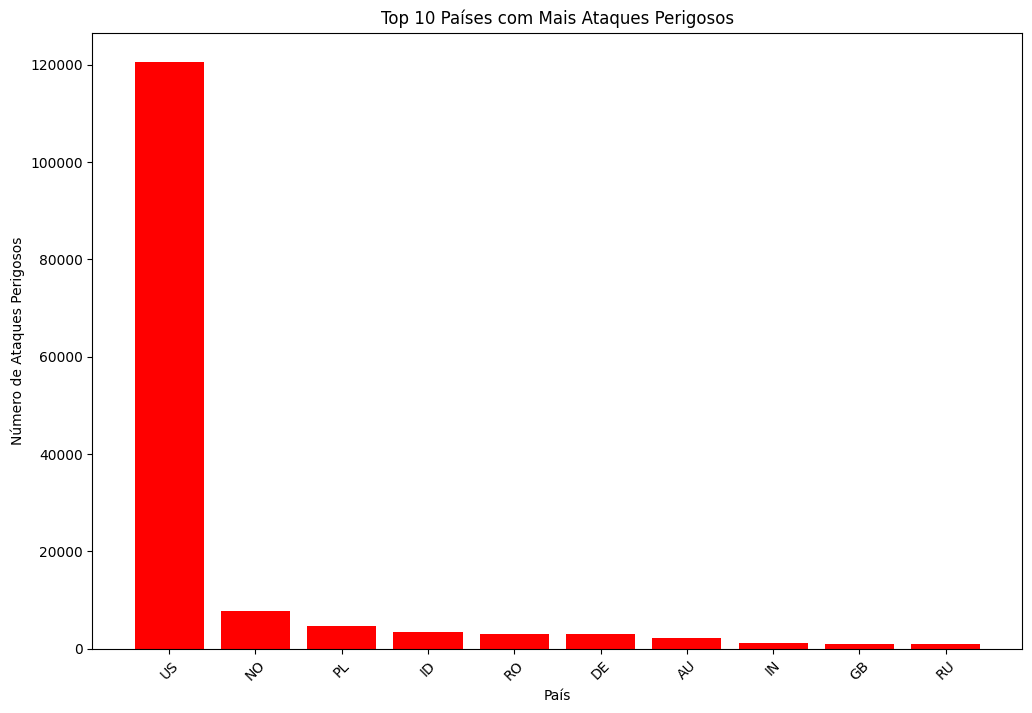

In [10]:
dangerous_attacks_df = df.filter(df['Is Attack IP'] == True)

attack_counts_by_country = dangerous_attacks_df.groupBy('Country').count()

top_10_countries = attack_counts_by_country.orderBy('count', ascending=False).limit(10)

top_10_countries_pd = top_10_countries.toPandas()

plt.figure(figsize=(12, 8))
plt.bar(top_10_countries_pd['Country'], top_10_countries_pd['count'], color='red')
plt.xlabel('País')
plt.ylabel('Número de Ataques Perigosos')
plt.title('Top 10 Países com Mais Ataques Perigosos')
plt.xticks(rotation=45)
plt.show()

Os Estados Unidos (US) destaca-se por ser, de longe, o país de onde originam mais logins de utilizadores caracterizados como IP's de Ataque.

#### ASN mais coumuns

In [11]:
df.groupBy('ASN') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+------+------+
|   ASN| count|
+------+------+
| 29695|405762|
|393398|366880|
| 15599| 82922|
| 41164| 72106|
|262582| 70123|
| 29492| 43417|
| 15659| 41062|
| 54903| 18620|
| 25400| 18272|
|205727| 17905|
+------+------+
only showing top 10 rows



In [12]:
unique_count = df.select("ASN").distinct().count()

# Show the count
print(f"Number of unique: {unique_count}")

Number of unique: 5648


#### Browser Name and Version

In [13]:
df.groupBy('Browser Name and Version') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+------------------------+-----+
|Browser Name and Version|count|
+------------------------+-----+
|           ZipppBot 0.11|82902|
|    Chrome Mobile 81....|71198|
|    Chrome 84.0.4147....|43265|
|    Opera Mobile 52.1...|42301|
|      Android 2.3.3.2660|38822|
|    Chrome Mobile 81....|36344|
|           VLC 3.0.0-git|35769|
|    Chrome Mobile 81....|34676|
|    Chrome Mobile Web...|33768|
|    Chrome Mobile Web...|33475|
+------------------------+-----+
only showing top 10 rows



Zippbot é o browser mais utilizado, segundo a tabela.
Temos depois várias versões do Chrome Mobile, que agregadas fariam com que o Chrome Mobile fosse o browser realmente mais utilizado para fazer login

In [14]:
unique_count = df.select("Browser Name and Version").distinct().count()

# Show the count
print(f"Number of unique: {unique_count}")

Number of unique: 2154


#### OS Name and Version

In [15]:
df.groupBy('OS Name and Version') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+-------------------+------+
|OS Name and Version| count|
+-------------------+------+
|         iOS 11.2.6|220296|
|   Mac OS X 10.14.6|218963|
|           iOS 13.4|189639|
|             Other |144494|
|        Android 4.1| 90222|
|    Mac OS X 11.6.3| 74483|
|        Android 2.2| 55168|
|       Android 13.0| 43316|
|     Android 6.0.99| 42715|
|         iOS 14.2.1| 42126|
+-------------------+------+
only showing top 10 rows



Os Sistemas Operativos mais comuns são, na sua maioria, os desenvolvidos pela Apple. Nomeadamente versões diferentes do iOS e MacOS.

In [16]:
unique_count = df.select("OS Name and Version").distinct().count()

# Show the count
print(f"Number of unique: {unique_count}")

Number of unique: 389


#### Device Type

In [17]:
df.groupBy('Device Type') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+-----------+------+
|Device Type| count|
+-----------+------+
|     mobile|981376|
|    desktop|396751|
|        bot|101289|
|    unknown| 43814|
|     tablet| 40377|
+-----------+------+



In [18]:
unique_count = df.select("Device Type").distinct().count()

# Show the count
print(f"Number of unique: {unique_count}")

Number of unique: 5


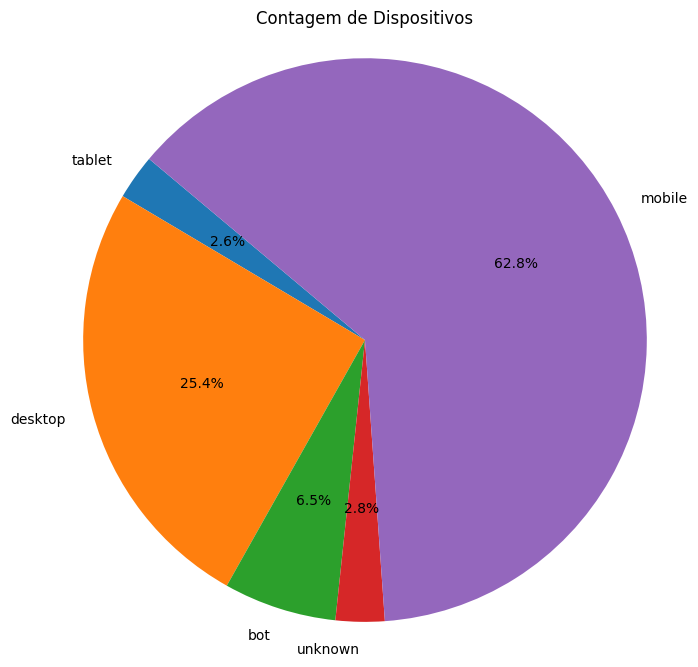

In [19]:
device_contagem = df.filter(df["Device Type"].isNotNull()) \
                         .groupBy("Device Type") \
                         .count()


device_contagem_pd = device_contagem.toPandas()


labels = device_contagem_pd['Device Type']
contagens = device_contagem_pd['count']


plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=140)


plt.title('Contagem de Dispositivos')


plt.axis('equal')
plt.show()

Observa-se que as tentativas de login são feitas, na maioria das vezes em dispositivos móveis e computadores


#### Login Successful

In [20]:
df.groupBy('Login Successful') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+----------------+------+
|Login Successful| count|
+----------------+------+
|           false|937696|
|            true|625911|
+----------------+------+



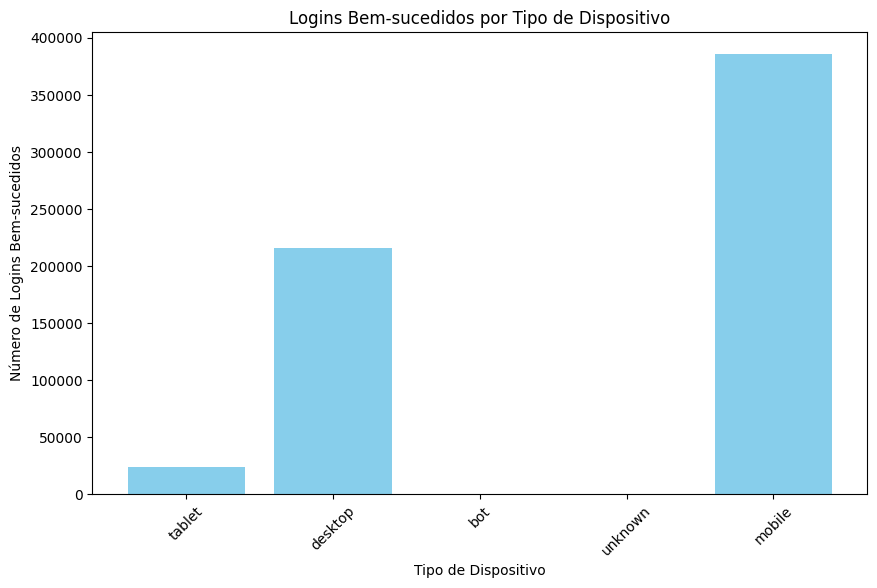

In [21]:
successful_logins_df = df.filter(df['Login Successful'] == True)


login_counts_by_device = successful_logins_df.groupBy('Device Type').count()
login_counts_by_device = login_counts_by_device.filter(login_counts_by_device["Device Type"].isNotNull())


login_counts_pd = login_counts_by_device.toPandas()



plt.figure(figsize=(10, 6))
plt.bar(login_counts_pd['Device Type'], login_counts_pd['count'], color='skyblue')
plt.xlabel('Tipo de Dispositivo')
plt.ylabel('Número de Logins Bem-sucedidos')
plt.title('Logins Bem-sucedidos por Tipo de Dispositivo')
plt.xticks(rotation=45)
plt.show()

A distribuição anterior mantem-se mesmo quando se observa tentativas de login bem sucedidas.

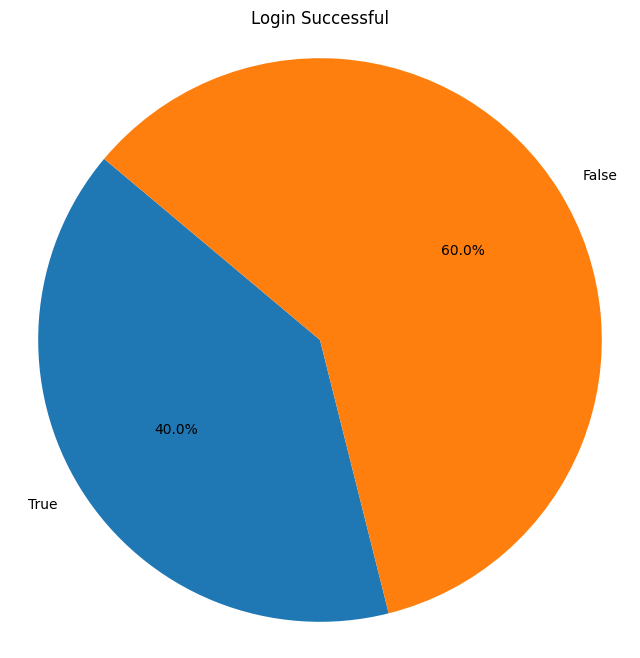

In [22]:

login_contagem = df.filter(df["Login Successful"].isNotNull()) \
                         .groupBy("Login Successful") \
                         .count()


login_contagem_pd = login_contagem.toPandas()


labels = login_contagem_pd['Login Successful']
contagens = login_contagem_pd['count']


plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=140)


plt.title('Login Successful')


plt.axis('equal')
plt.show()

Existe uma proporção de 60% de falha na tentativa de login para 40% de sucesso.

#### ip_classification

In [23]:
(df
    .groupBy('ip_classification')
    .count()
    .show()
)

+-----------------+-------+
|ip_classification|  count|
+-----------------+-------+
|           Public|1198983|
|          Private| 364624|
+-----------------+-------+



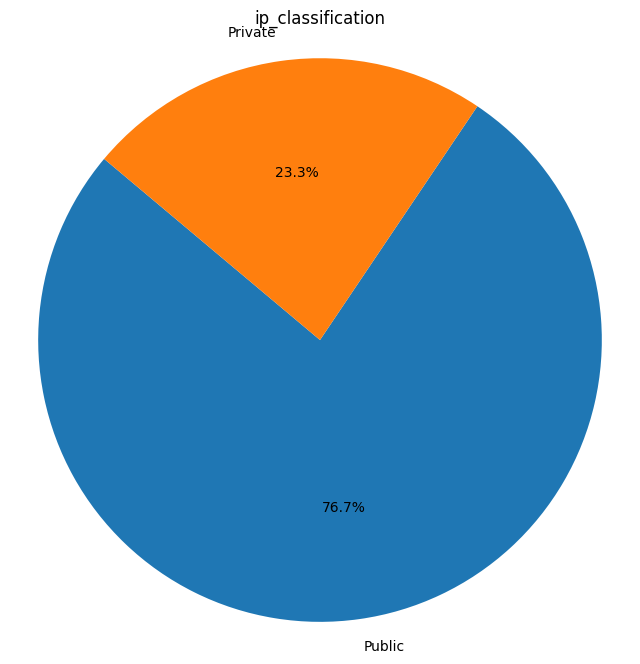

In [26]:
isatt_contagem = df.filter(df["ip_classification"].isNotNull()) \
                         .groupBy("ip_classification") \
                         .count()


isatt_contagem_pd = isatt_contagem.toPandas()


labels = isatt_contagem_pd['ip_classification']
contagens = isatt_contagem_pd['count']


plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=140)


plt.title('ip_classification')


plt.axis('equal')
plt.show()

Observa-se uma predominância de Ips públicos com 76.7% para os 23.3% de Ips privados.


#### Dangerous IP

In [27]:
(df
    .groupBy('Dangerous IP')
    .count()
    .show()
)

+------------+-------+
|Dangerous IP|  count|
+------------+-------+
|        true| 137344|
|       false|1426263|
+------------+-------+



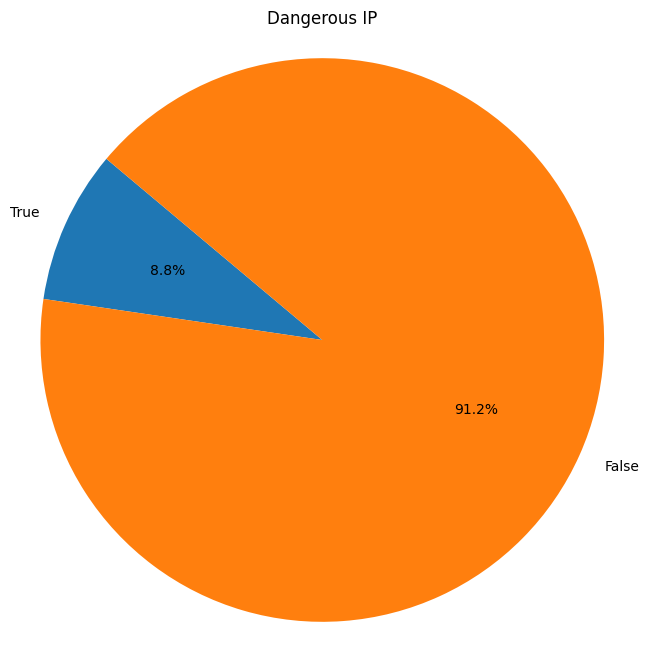

In [28]:
isatt_contagem = df.filter(df["Dangerous IP"].isNotNull()) \
                         .groupBy("Dangerous IP") \
                         .count()


isatt_contagem_pd = isatt_contagem.toPandas()


labels = isatt_contagem_pd['Dangerous IP']
contagens = isatt_contagem_pd['count']


plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=140)


plt.title('Dangerous IP')


plt.axis('equal')
plt.show()

In [29]:
df.filter(df['IP Address'] == '10.0.0.103') \
    .groupBy('Dangerous IP') \
    .count() \
    .orderBy('count', ascending=False) \
    .show()

+------------+-----+
|Dangerous IP|count|
+------------+-----+
|        true|   57|
|       false|    1|
+------------+-----+



Como podemos observar , na maioria dos casos os IPs não são perigosos.
Mas , quando são esta variável apenas retorna false na primeira vez em que vê o IP.

#### Is Attack IP

In [24]:
df.groupBy('Is Attack IP') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(10)

+------------+-------+
|Is Attack IP|  count|
+------------+-------+
|       false|1409286|
|        true| 154321|
+------------+-------+



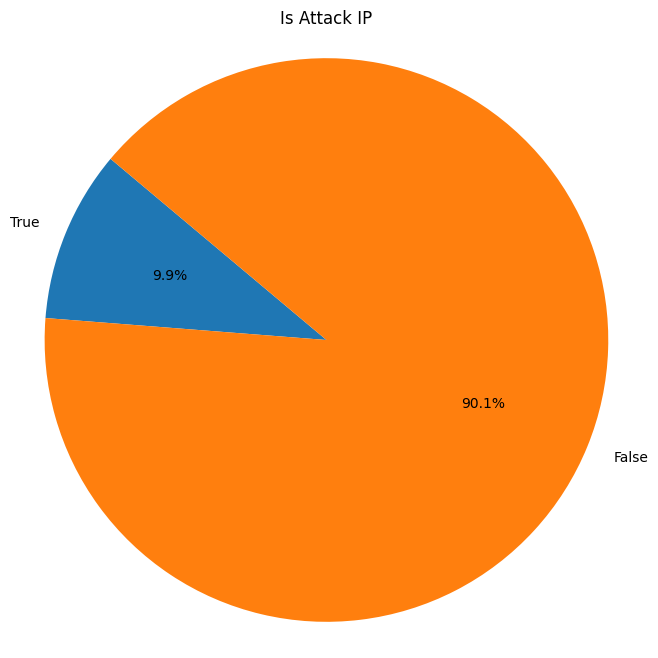

In [25]:
isatt_contagem = df.filter(df["Is Attack IP"].isNotNull()) \
                         .groupBy("Is Attack IP") \
                         .count()


isatt_contagem_pd = isatt_contagem.toPandas()


labels = isatt_contagem_pd['Is Attack IP']
contagens = isatt_contagem_pd['count']


plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=140)


plt.title('Is Attack IP')


plt.axis('equal')
plt.show()

Esta é a nossa variável alvo, observa-se predominância de logins que não são ataques